In [5]:
from augur.utils import json_to_tree
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.gridspec as gridspec
import seaborn as sns
from scipy import stats
import numpy as np
import pandas as pd
from Bio import SeqIO
from Bio.Seq import Seq
from Bio.Seq import MutableSeq
from collections import Counter
import requests
import random
import math
import json
from scipy import stats

Make an expectation for wait times by randomly putting mutations on tree and then calculating wait times

In [6]:
tree_url = 'https://nextstrain-blab.s3.amazonaws.com/ncov_adaptive-evolution.json'

tree_json = requests.get(tree_url).json()

#Put tree in Bio.Phylo format
tree = json_to_tree(tree_json)

In [7]:
# #Download tree json
# # tree_url = "https://data.nextstrain.org/ncov_gisaid_global.json"
# tree_url = "https://data.nextstrain.org/ncov_global_2021-05-19.json"

# tree_json = requests.get(tree_url).json()

# #Put tree in Bio.Phylo format
# tree = json_to_tree(tree_json)

Find the actual number of S1 and RdRp mutations

In [8]:
#Function to find path from root to clade
def get_parent(tree, child_clade):
    node_path = tree.get_path(child_clade)
    return node_path

In [9]:
def consolidate_deletions(mutation_list):
    """
    For deletion mutations, consider adjacent sites as part of the same deletion
    """
    
    without_deletions = [x for x in mutation_list if x[-1]!='-' and x[0]!='-']
    #consolidate deletions and reversions
    deletions_only = [x for x in mutation_list if x[-1]=='-' or x[0]=='-']
    deletions_only.sort(key=lambda x:x[1:-1])
    
    
    #keep track of start of separate deletions
    separate_deletions = []

    # if there are deletions, count a run of consecutive sites as a single deletion/mutation
    if len(deletions_only) != 0:
        separate_deletions.append(deletions_only[0])

        deletion_tracker = int(deletions_only[0][1:-1])
        
        for deletion in deletions_only[1:]:

            deleted_pos = int(deletion[1:-1])
            if deleted_pos == deletion_tracker+1:
                pass
            else:
                separate_deletions.append(deletion)
            deletion_tracker = deleted_pos
    
    consolidated_mutation_list = separate_deletions + without_deletions
            
    return consolidated_mutation_list

In [10]:
# make dictionary with gene name as key and reference sequence of that gene as value
reference_sequence_aa = {}
reference_sequence_nt = {}


# make dictionary giving gene by genomic location 
reference_gene_locations = {}

# make dictionary saying what codon within the gene a certain genomic location falls within
# and whether the mutation is at pos 0, 1 or 2 within codon
reference_gene_codon = {}

for record in SeqIO.parse(open("reference_seq_edited.gb","r"), "genbank"):
    genome_seq = record.seq
    for feature in record.features:
        if feature.type == 'CDS':
            # allow RdRp to overwrite Orf1a and Orf1b, 
            # to take care of changed reading frame due to  ribosome slippage
            # S1 and S2 will also overwrite spike
            for pos in range(int(feature.location.start), int(feature.location.end)):
                reference_gene_locations[pos] = feature.qualifiers['gene'][0]
                codon_num = math.floor((pos-feature.location.start)/3)
                pos_in_codon = ((pos-feature.location.start)-codon_num*3)
                reference_gene_codon[pos] = (codon_num, pos_in_codon)
                
            gene_seq = feature.location.extract(record.seq)
            reference_sequence_nt[feature.qualifiers['gene'][0]] = gene_seq
            gene_seq_aa = gene_seq.translate()
            reference_sequence_aa[feature.qualifiers['gene'][0]] = gene_seq_aa

/Users/katekistler/anaconda3/envs/ncov/lib/python3.6/site-packages/Bio/Seq.py:2859: BiopythonWarning: Partial codon, len(sequence) not a multiple of three. Explicitly trim the sequence or add trailing N before translation. This may become an error in future.
  BiopythonWarning,


In [11]:
def nuc_changes_from_reference(muts_on_path):
    """
    From all the of the nucleotide changes that have occurred on the path from root to branch, 
    find the most recent nuc mutation at each site (giving the genotype at the branch)
    """
    
    final_muts_from_ref = {}

    # overwrites genotypes at pos in historical order
    for x in muts_on_path:
        x_pos = int(x[1:-1])
        final_muts_from_ref[x_pos] = x[-1]
        

    return final_muts_from_ref

In [12]:
def determine_synonymous(nuc_muts_on_branch, parent_diffs_from_ref):
    
    parent_diffs_pos = [int(k) for k,v in parent_diffs_from_ref.items()]

    
    # make dictionary of synonymous (and noncoding) mutations to add to tree
    syn_muts = {}
    
    # don't care about deletions because they are obviously not synonymous
    for mut in nuc_muts_on_branch:
        if mut[-1]!= '-' and mut[0]!='-':
            mut_pos = int(mut[1:-1])
            # find what gene this mut happens in
            if (mut_pos-1) in reference_gene_locations.keys():
                mut_gene = reference_gene_locations[mut_pos-1]
                mut_codon_num = reference_gene_codon[mut_pos-1][0]
                mut_codon_pos = reference_gene_codon[mut_pos-1][1]
                
                # find the reference sequence of the codon this mutation occurs in
                codon_ref_aa = reference_sequence_aa[mut_gene][mut_codon_num]
                
                codon_ref_nt = reference_sequence_nt[mut_gene][(mut_codon_num*3):(mut_codon_num*3+3)]
                
                # check if a mutation occurred within the same codon in a parent
                # and if so, change the reference codon sequence accordingly, 
                # to tell whether the mutation at this branch is synonymous or not
                codon_genome_pos = list(range((mut_pos-1-mut_codon_pos),(mut_pos-1-mut_codon_pos+3)))
                
                parent_codon = codon_ref_nt
                for parent_diff in parent_diffs_pos:
                    parent_diff_zero_based = parent_diff-1
                    if parent_diff_zero_based in codon_genome_pos:
                        parent_diff_pos = codon_genome_pos.index(parent_diff_zero_based)
                        parent_codon = MutableSeq(str(codon_ref_nt))
                        parent_codon[parent_diff_pos] = parent_diffs_from_ref[parent_diff]
                        parent_codon = parent_codon.toseq()
                
                
                codon_mutated = MutableSeq(str(parent_codon))
                #if deletion (or seq error) has happened at neighboring nucleotide
                if '-' in codon_mutated:
                    pass
                else:
                    codon_mutated[mut_codon_pos] = mut[-1]
                    codon_mutated = codon_mutated.toseq()
                    codon_mutated_translation = codon_mutated.translate()

                    if str(codon_ref_aa) == str(codon_mutated_translation):
                        if mut_gene in syn_muts.keys():
                            syn_muts[mut_gene] += [mut]
                        else:
                            syn_muts[mut_gene] = [mut]
                        
                

            else:
                if 'noncoding' in syn_muts.keys():
                    syn_muts['noncoding'] += [mut]
                else:
                    syn_muts['noncoding'] = [mut]
                    
    return syn_muts

In [13]:
def add_syn_mut_attribute(tree):
    
    for node in tree.find_clades():

        node.node_attrs['syn_muts'] = {}

        # only care if this branch has some nucleotide mutations
        if hasattr(node, 'branch_attrs'):
            if 'nuc' in node.branch_attrs['mutations']:

                nuc_muts_on_branch = node.branch_attrs['mutations']['nuc']

                node_path = get_parent(tree, node)

                nucleotide_mut_path = []

                # find all nucleotide mutations that happened in parents, 
                # in case they affect codons mutated on this branch
                for parent in node_path[-1]:
                    if hasattr(parent, 'branch_attrs'):
                        if 'nuc' in parent.branch_attrs['mutations']:
                            nucleotide_mut_path+=parent.branch_attrs['mutations']['nuc']

                parent_diffs_from_ref = nuc_changes_from_reference(nucleotide_mut_path)

                syn_muts_dict = determine_synonymous(nuc_muts_on_branch, parent_diffs_from_ref)

                node.node_attrs['syn_muts'] = syn_muts_dict


In [14]:
add_syn_mut_attribute(tree)

In [15]:
for node in tree.find_clades(terminal=False):

    node.s1_nonsyn_at_node = 0
    node.s1_syn_at_node = 0
    node.rdrp_nonsyn_at_node = 0

    if hasattr(node, "node_attrs") and 'S1' in node.node_attrs['syn_muts']:
        node.s1_syn_at_node = len(node.node_attrs['syn_muts']['S1'])


    if hasattr(node, 'branch_attrs'):

        s1_nonsyn_at_this_node = []
        if "S" in node.branch_attrs["mutations"]:
            for mut in node.branch_attrs["mutations"]["S"]:
                if int(mut[1:-1]) in range(14,686):
                    s1_nonsyn_at_this_node.append(mut)

        s1_consolidated = consolidate_deletions(s1_nonsyn_at_this_node)
        node.s1_nonsyn_at_node = len(s1_consolidated)



        rdrp_nonsyn_at_this_node = []
        if "ORF1a" in node.branch_attrs["mutations"]:
            for mut in node.branch_attrs["mutations"]["ORF1a"]:
                if int(mut[1:-1]) in range(4492,4401):
                    rdrp_nonsyn_at_this_node.append(mut)


        if "ORF1b" in node.branch_attrs["mutations"]:
            for mut in node.branch_attrs["mutations"]["ORF1b"]:
                if int(mut[1:-1]) in range(1,923):
                    rdrp_nonsyn_at_this_node.append(mut)

        rdrp_consolidated = consolidate_deletions(rdrp_nonsyn_at_this_node)
        node.rdrp_nonsyn_at_node = len(rdrp_consolidated)


In [16]:
# find number of nodes that have S1 mutations
# consider only internal branches
nodes_with_s1_nonsyn = 0
total_s1_nonsyn = 0
nodes_with_s1_syn = 0
total_s1_syn = 0

for node in tree.find_clades(terminal=False):
    # look only at nodes with at least 5 descendents, to exclude weird stuff at tips and sequencing errors
    if len(node.get_terminals()) >=3:
        if node.s1_nonsyn_at_node!= 0:
            nodes_with_s1_nonsyn+=1
            total_s1_nonsyn += node.s1_nonsyn_at_node
        if node.s1_syn_at_node!=0:
            nodes_with_s1_syn+=1
            total_s1_syn += node.s1_syn_at_node
        
        
print(f'Nodes with S1 nonsyn mutations: {nodes_with_s1_nonsyn}')
print(f'Total number of S1 nonsyn mutations: {total_s1_nonsyn}')
print(f'Nodes with S1 syn mutations: {nodes_with_s1_syn}')
print(f'Total number of S1 syn mutations: {total_s1_syn}')


# find number of nodes that have RdRp mutations
nodes_with_rdrp_muts = 0
total_rdrp_muts = 0

for node in tree.find_clades(terminal=False):
    # look only at nodes with at least 5 descendents, to exclude sequencing errors
    if len(node.get_terminals()) >=3:
        if node.rdrp_nonsyn_at_node!= 0:
            nodes_with_rdrp_muts+=1
            total_rdrp_muts += node.rdrp_nonsyn_at_node
        
print(f'Nodes with RdRp mutations: {nodes_with_rdrp_muts}')
print(f'Total number of RdRp mutations: {total_rdrp_muts}')

first_timepoint = tree.root.node_attrs['num_date']['value']
last_timepoint = 0
for node in tree.find_clades(terminal=False):
    if node.node_attrs['num_date']['value'] > last_timepoint:
        last_timepoint = node.node_attrs['num_date']['value']
        
print(f'Time window: {first_timepoint}-{last_timepoint}')
    

Nodes with S1 nonsyn mutations: 277
Total number of S1 nonsyn mutations: 353
Nodes with S1 syn mutations: 100
Total number of S1 syn mutations: 104
Nodes with RdRp mutations: 98
Total number of RdRp mutations: 101
Time window: 2019.982929101653-2021.3404645014461


In [17]:
total_branchs = 0
for node in tree.find_clades(terminal=False):
    if len(node.get_terminals()) >=3:
        total_branchs+=1

In [18]:
# find all branch lengths
root_date = tree.root.node_attrs['num_date']['value']

# keep track of parts of paths that have already been considered
paths_segments_already_used_all = []

# store all wait times between branchs
branch_lengths_all = []
branch_names_all = []

for node in tree.find_clades(terminal=False):
    
    if len(node.get_terminals()) >=3:


        node_path = get_parent(tree, node)

        # find the branch length (in decimal years) between node and previous node
        path_dates = [n.node_attrs['num_date']['value'] for n in node_path]

        if len(path_dates) > 1:
            path_dates_with_root = [root_date] + path_dates
            branch_lengths = [j-i for i, j in zip(path_dates_with_root[:-1], path_dates_with_root[1:])]

    #         branch_lengths = [j-i for i, j in zip(path_dates[:-1], path_dates[1:])]


            for n_index in range(len(node_path)):

                # name of the node at the end of the branch
                # branch length will be assigned to this node because 
                # it is the length of the branch leading to this node
                branch_name = node_path[n_index].name
                if n_index==0:
                    preceding_node_name = tree.root.name
                else:
                    preceding_node_name = node_path[n_index-1].name


                if [preceding_node_name, branch_name] not in paths_segments_already_used_all:

                    branch_length = branch_lengths[n_index]

                    if branch_length<0:
                        branch_length = 0.0

                    branch_lengths_all.append(branch_length)
                    branch_names_all.append(branch_name)
    #                 branch_names_all.append([root_name, branch_name])
                    paths_segments_already_used_all.append([preceding_node_name, branch_name])

            


Throw each of the S1 mutations onto a random branch of the tree by picking a random branch X times (where X= total number of S1 mutations). Can result in multiple hits on same branch (as with empirical data)

In [19]:
def randomize_mutations_on_tree_multinomial(num_mutations, branch_lengths, branch_names):
    
    # multinomial draw to randomize mutations on tree
    branch_lengths_normalized = [x/sum(branch_lengths) for x in branch_lengths]

    num_branches = len(branch_lengths_normalized)

    hits = list(np.random.multinomial(num_mutations, branch_lengths_normalized, size=1))[0]
    
    muts_on_branch = dict(zip(branch_names, hits))

    for node in tree.find_clades(terminal=False):
        if len(node.get_terminals()) >=3:
        # no branch length at root
            if node.name == 'NODE_0000000':
                node.random_muts = 0

            else:
                node.random_muts = muts_on_branch[node.name] 


        

Find the wait times between S1 (or RdRp) mutations. Do not double count paths between mutations. Mutations on parent brnaches can give rise to multiple wait times (see analog notebook for sketch)

In [20]:
# to deal with branches with multiple mutations, say that each mutation happens at a randomly chosen time 
# between the node and previous node

def random_wait_times():
    root_date = tree.root.node_attrs['num_date']['value']

    # keep track of parts of paths that have already been considered
    paths_segments_already_used_random = []

    # keep track of nodes (with multiple S1 mutations) where the wait times 
    # of 0 (between those mutations) have already been counted
    wait_times_already_counted_at_node = []

    # store all wait times between observed mutations
    all_wait_times_random = []



    for node in tree.find_clades(terminal=False):
        
        if len(node.get_terminals()) >=3:



            node_path = get_parent(tree, node)

            # find the branch length (in decimal years) between node and previous node
            path_dates = [n.node_attrs['num_date']['value'] for n in node_path]

            if len(path_dates) > 0:
                path_dates_with_root = [root_date] + path_dates
                branch_lengths = [j-i for i, j in zip(path_dates_with_root[:-1], path_dates_with_root[1:])]

            random_muts_on_path = [n.random_muts for n in node_path]
            # indicies of branches that have S1 mutations
            random_mut_indicies = [i for i, num_random in enumerate(random_muts_on_path) if num_random!=0]

            # count wait time from root until first mutation(s)
            if len(random_mut_indicies) == 1:
                A_name = node_path[random_mut_indicies[0]].name
                root_name = node_path[0].name

                if [root_name, A_name] not in paths_segments_already_used_random:
                    num_muts_A = random_muts_on_path[random_mut_indicies[0]]

                    # pick date for branch A randomly between inferred node date and previous node 
                    # because mutation happened somewhere in this time window, not necessarily right at the node
                    node_date_A = node_path[random_mut_indicies[0]].node_attrs['num_date']['value']

                    # if there are multiple mutations at this branch, assign each of them a different random date
                    dates_A = []
                    for mut in range(num_muts_A):
                        date_A = random.uniform(node_date_A - branch_lengths[random_mut_indicies[0]], node_date_A)
                        dates_A.append(date_A)

                    dates_A = sorted(dates_A)

                    # prepend the root date
                    dates_A = [root_date] + dates_A

                    # find wait times between this branch and the root and between mutations on this branch
                    wait_times = [j-i for i, j in zip(dates_A[:-1], dates_A[1:])]
                    all_wait_times_random+=wait_times

                    paths_segments_already_used_random.append([root_name, A_name])
                    wait_times_already_counted_at_node.append(A_name)



            # if more than 1 mutation is on this path, calculate wait time between mutations
            if len(random_mut_indicies) > 1:

                for x in range(len(random_mut_indicies) -1):

                    A_name = node_path[random_mut_indicies[x]].name
                    B_name = node_path[random_mut_indicies[x+1]].name

                    # only count wait times if this path segment hasn't already been counted
                    if [A_name, B_name] not in paths_segments_already_used_random:

                        num_muts_A = random_muts_on_path[random_mut_indicies[x]]
                        num_muts_B = random_muts_on_path[random_mut_indicies[x+1]]

                        # pick dates for branches A and B randomly between inferred node date and previous node 
                        # because mutation happened somewhere in this time window, not necessarily right at the node


                        # if there are multiple mutations on these branch, assign each of them a different random date
                        node_date_A = node_path[random_mut_indicies[x]].node_attrs['num_date']['value']
                        dates_A = []
                        for mut in range(num_muts_A):
                            date_A = random.uniform(node_date_A - branch_lengths[random_mut_indicies[x]], node_date_A)
                            dates_A.append(date_A)

                        dates_A = sorted(dates_A)


                        node_date_B = node_path[random_mut_indicies[x+1]].node_attrs['num_date']['value']
                        dates_B = []
                        for mut in range(num_muts_B):
                            date_B = random.uniform(node_date_B - branch_lengths[random_mut_indicies[x+1]], node_date_B)
                            dates_B.append(date_B)

                        dates_B = sorted(dates_B)


                        # find wait times between mutations on one branch
                        # only if this node hasn't already been counted
                        if A_name not in wait_times_already_counted_at_node:
                            wait_times_on_A = [j-i for i, j in zip(dates_A[:-1], dates_A[1:])]
                            all_wait_times_random+=wait_times_on_A
                            wait_times_already_counted_at_node.append(A_name)

                        if B_name not in wait_times_already_counted_at_node:
                            wait_times_on_B = [j-i for i, j in zip(dates_B[:-1], dates_B[1:])]
                            all_wait_times_random+=wait_times_on_B
                            wait_times_already_counted_at_node.append(B_name)

                        # and between latest mutation on branch A and earliest on branch B 
                        wait_time_between = dates_B[0] - dates_A[-1]
                        all_wait_times_random.append(wait_time_between)



                        # add this pair of branches to the list of path segments that have already been counted
                        paths_segments_already_used_random.append([A_name, B_name])

    return all_wait_times_random

In [21]:
def wait_time_stats(tree_url, genes, iterations, save_filename):
    #Download tree json
    tree_json = requests.get(tree_url).json()

    #Put tree in Bio.Phylo format
    tree = json_to_tree(tree_json)
    
    wait_times_stats_dict = {'wait_times_stats':[]}
    
    for gene in genes:
        if gene == 'rdrp':
            nonsyn_syn_options=['nonsyn']
        elif gene == 's1':
            nonsyn_syn_options=['nonsyn', 'syn']
        
        for nonsyn_syn in nonsyn_syn_options:

            for x in range(iterations):
                if gene == 'rdrp':
                    randomize_mutations_on_tree_multinomial(total_rdrp_muts, branch_lengths_all, branch_names_all)

                elif gene == 's1':
                    if nonsyn_syn == 'nonsyn':
                        randomize_mutations_on_tree_multinomial(total_s1_nonsyn, branch_lengths_all, branch_names_all)
                    elif nonsyn_syn == 'syn':
                        randomize_mutations_on_tree_multinomial(total_s1_syn, branch_lengths_all, branch_names_all)

                wait_times_random = random_wait_times()
                
                mean_wait_time_random = sum(wait_times_random)/len(wait_times_random)
                
                under_02_random = len([x for x in wait_times_random if x<=0.2])/len(wait_times_random)
                under_04_random = len([x for x in wait_times_random if x<=0.4])/len(wait_times_random)
                under_06_random = len([x for x in wait_times_random if x<=0.6])/len(wait_times_random)
                
                # store mean wait time per randomization iteration. Also proportion under 0.2, 0.4, 0.6 years
                wait_times_stats_dict['wait_times_stats'].append({'data': 'expected', 'gene': gene, 'nonsyn_syn': nonsyn_syn,
                                                        'wait_times': wait_times_random,
                                                        'mean_wait_time': mean_wait_time_random, 
                                                        'proportion_under_02': under_02_random, 
                                                        'proportion_under_04': under_04_random, 
                                                        'proportion_under_06': under_06_random})


            
            # find these values for empirical data too 
            # do multiple iterations as well because date of mutation is picked randomly along branch length
            for x in range(iterations):
                if gene == 's1':
                    all_wait_times_s1 = s1_wait_times(nonsyn_syn)
                    wait_times_empirical = all_wait_times_s1
                elif gene == 'rdrp':
                    all_wait_times_rdrp = rdrp_wait_times()
                    wait_times_empirical = all_wait_times_rdrp
                    
                mean_wait_time_empirical = sum(wait_times_empirical)/len(wait_times_empirical)
                
                under_02_empirical = len([x for x in wait_times_empirical if x<=0.2])/len(wait_times_empirical)
                under_04_empirical = len([x for x in wait_times_empirical if x<=0.4])/len(wait_times_empirical)
                under_06_empirical = len([x for x in wait_times_empirical if x<=0.6])/len(wait_times_empirical)
                
                # store mean wait time per  iteration. Also proportion under 0.2, 0.4, 0.6 years
                wait_times_stats_dict['wait_times_stats'].append({'data': 'observed', 'gene': gene, 'nonsyn_syn': nonsyn_syn,
                                                        'wait_times': wait_times_empirical,
                                                        'mean_wait_time': mean_wait_time_empirical, 
                                                        'proportion_under_02': under_02_empirical, 
                                                        'proportion_under_04': under_04_empirical, 
                                                        'proportion_under_06': under_06_empirical})

    with open(save_filename, 'w') as outfile:
        json.dump(wait_times_stats_dict, outfile)

    

In [ ]:
wait_time_stats('https://nextstrain-blab.s3.amazonaws.com/ncov_adaptive-evolution.json', ['s1', 'rdrp'], 50,  
                'wait_time_stats/wait_time_stats_150_internal.json')

In [42]:
def plot_fig2b(data_files, filename=None):

        # dataframe for all wait time information, 
    # each row is an iteration for expected or observed, s1 or rdrp, syn or nonsyn
    to_plot = pd.DataFrame(columns = ['data', 'gene', 'nonsyn_syn',
                                         'wait_times', 'mean_wait_time', 
                                         'proportion_under_02', 'proportion_under_04',
                                         'proportion_under_06', 'proportion_under_08'])
    
    for data_file in data_files:
        with open(data_file) as json_file:
            data = json.load(json_file)
            df = pd.DataFrame(data['wait_times_stats'])
            to_plot = pd.concat([to_plot, df])

    
    fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20,4), sharey=True)
    sns.set_style("white")
    

    cmap1 = {'expected':"#ABABAB",'observed':"#4770eb"}
    cmap2 = {'expected':"#ABABAB",'observed':"#5094e3"}
    cmap3 = {'expected':"#ABABAB",'observed':"#ff8c3a"}
    
    to_plot = to_plot.explode('wait_times').reset_index()

    
    ax1 = sns.histplot(data=to_plot[(to_plot['gene']=='s1') & (to_plot['nonsyn_syn']=='nonsyn')], 
                       x='wait_times', hue='data', 
                      palette = cmap1, hue_order=['expected','observed'],
                      element = 'step',
                      bins=20, 
                      common_norm = False, stat='probability', ax=ax1)
    ax1.legend(handles=ax1.legend_.legendHandles, labels=[t.get_text() for t in ax1.legend_.texts],
              title='',
              bbox_to_anchor=(0.65, 0.95), loc='upper left', fontsize=12)
    
    ax2 = sns.histplot(data=to_plot[(to_plot['gene']=='s1') & (to_plot['nonsyn_syn']=='syn')], 
                       x='wait_times', hue='data', 
                      palette = cmap2, hue_order=['expected','observed'],
                      element = 'step',
                      bins=20, 
                      common_norm = False, stat='probability', ax=ax2)
    ax2.legend(handles=ax2.legend_.legendHandles, labels=[t.get_text() for t in ax2.legend_.texts],
              title='',
              bbox_to_anchor=(0.65, 0.95), loc='upper left', fontsize=12)
    
    ax3 = sns.histplot(data=to_plot[(to_plot['gene']=='rdrp') & (to_plot['nonsyn_syn']=='nonsyn')], 
                       x='wait_times', hue='data', 
                      palette = cmap3, hue_order=['expected','observed'],
                      element = 'step',
                      bins=20, 
                      common_norm = False, stat='probability', ax=ax3)
    ax3.legend(handles=ax3.legend_.legendHandles, labels=[t.get_text() for t in ax3.legend_.texts],
              title='',
              bbox_to_anchor=(0.65, 0.95), loc='upper left', fontsize=12)



    ax1.set_title(f'S1 nonsynonymous', fontsize = 18)
    ax2.set_title(f'S1 synonymous', fontsize = 18)
    ax3.set_title(f'RdRp nonsynonymous', fontsize = 18)
    
    ax1.set_xlabel('wait time', fontsize=16)
    ax2.set_xlabel('wait time', fontsize=16)
    ax3.set_xlabel('wait time', fontsize=16)
    
    for ax in [ax1, ax2, ax3]:
        ax.set_ylabel('probability', fontsize = 16)
        ax.tick_params(axis='both', which='major', labelsize=12)
    
    
    sns.despine(left=False, bottom=False)
    plt.subplots_adjust(wspace=0.1)
    
    plt.figtext(0.08, 0.96, 'B', fontsize=24, fontweight='bold')

    if filename:
        fig.savefig(filename, dpi=300, bbox_inches='tight')
    
    

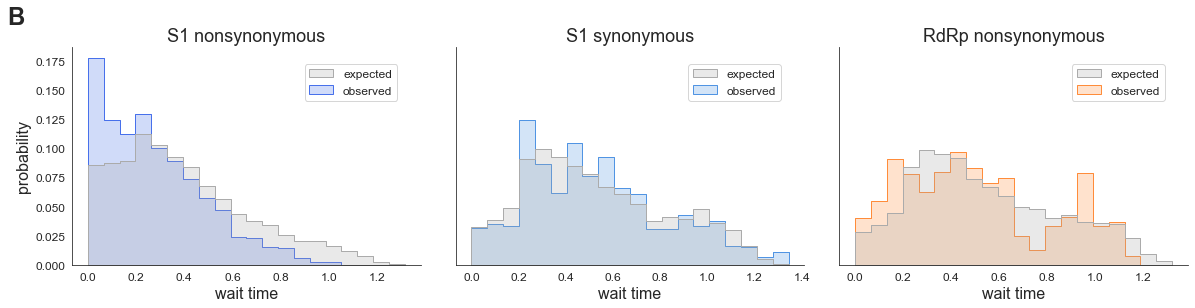

In [43]:
plot_fig2b(['wait_time_stats/wait_time_stats_50_internal.json'], filename = 'plots/fig2b_20210515.png')

In [33]:
def plot_wait_time_stats(data_files, filename=None):
    
    # dataframe for all wait time information, 
    # each row is an iteration for expected or observed, s1 or rdrp, syn or nonsyn
    to_plot_df = pd.DataFrame(columns = ['data', 'gene', 'nonsyn_syn',
                                         'wait_times', 'mean_wait_time', 
                                         'proportion_under_02', 'proportion_under_04',
                                         'proportion_under_06', 'proportion_under_08'])
    
    for data_file in data_files:
        with open(data_file) as json_file:
            data = json.load(json_file)
            df = pd.DataFrame(data['wait_times_stats'])
            to_plot_df = pd.concat([to_plot_df, df])
            
    proportion_under_03 = []
    proportion_03_08 = []
    proportion_over_08 = []
    for k,v in to_plot_df.iterrows():
        proportion_under_03.append(len([x for x in v.wait_times if x<=0.3])/len([x for x in v.wait_times]))
        proportion_03_08.append(len([x for x in v.wait_times if x>=0.3 and x<=0.8])/len([x for x in v.wait_times]))
        proportion_over_08.append(len([x for x in v.wait_times if x>=0.8])/len([x for x in v.wait_times]))
    to_plot_df['proportion_under_03'] = proportion_under_03  
    to_plot_df['proportion_03_08'] = proportion_03_08
    to_plot_df['proportion_over_08'] = proportion_over_08
    

            
    num_iterations = len(to_plot_df)/6
            
    # subset the dataframe into different genes, data types
    s1_n_expected_df = to_plot_df[(to_plot_df['gene']=='s1') & (to_plot_df['nonsyn_syn']=='nonsyn') & 
                         (to_plot_df['data']=='expected')]
    s1_n_observed_df = to_plot_df[(to_plot_df['gene']=='s1') & (to_plot_df['nonsyn_syn']=='nonsyn') & 
                         (to_plot_df['data']=='observed')]
    
    
    s1_s_expected_df = to_plot_df[(to_plot_df['gene']=='s1') & (to_plot_df['nonsyn_syn']=='syn') & 
                         (to_plot_df['data']=='expected')]
    s1_s_observed_df = to_plot_df[(to_plot_df['gene']=='s1') & (to_plot_df['nonsyn_syn']=='syn') & 
                         (to_plot_df['data']=='observed')]
    
    rdrp_n_expected_df = to_plot_df[(to_plot_df['gene']=='rdrp') & (to_plot_df['nonsyn_syn']=='nonsyn') & 
                         (to_plot_df['data']=='expected')]
    rdrp_n_observed_df = to_plot_df[(to_plot_df['gene']=='rdrp') & (to_plot_df['nonsyn_syn']=='nonsyn') & 
                         (to_plot_df['data']=='observed')]

    
    f = plt.figure(figsize=(20,4))

    gs = gridspec.GridSpec(2, 3, height_ratios=[2.5,1])

    ax1 = plt.subplot(gs[0])
    ax2 = plt.subplot(gs[1], sharey=ax1, sharex=ax1)
    ax3 = plt.subplot(gs[2], sharey=ax1, sharex=ax1) 
    
    ax4 = plt.subplot(gs[3], sharey=ax1) 
    ax5 = plt.subplot(gs[4], sharey=ax1, sharex=ax4) 
    ax6 = plt.subplot(gs[5], sharey=ax1, sharex=ax4)

    

#     fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2,3, figsize=(20,4), sharey=True)
    sns.set_style("white")

    
    ax1 = sns.histplot(data=s1_n_expected_df, 
                       x='mean_wait_time', color = "#ABABAB",
                      element = 'step',alpha=0.25,
                      bins=10, stat='count', ax=ax1)
    s1_nonsyn_mean = s1_n_observed_df['mean_wait_time'].mean()
    ax1.axvline(x=s1_nonsyn_mean, color = "#4770eb", linewidth=4)
    
    # find p-value
    s1_n_p_value = len(s1_n_expected_df[s1_n_expected_df['mean_wait_time']<s1_nonsyn_mean])/num_iterations
    if s1_n_p_value==0.0:
        s1_n_p_value = '< 0.001'
    else:
        s1_n_p_value= round(s1_n_p_value,4)
    ax1.annotate(f'p-value: {s1_n_p_value}', xy=(0.06, 0.90), xycoords='axes fraction', size=12, fontweight='bold')

    
    ax2 = sns.histplot(data=s1_s_expected_df, 
                       x='mean_wait_time', color = "#ABABAB",
                      element = 'step',alpha=0.25,
                      bins=10, stat='count', ax=ax2)
    
    s1_syn_mean = s1_s_observed_df['mean_wait_time'].mean()
    ax2.axvline(x=s1_syn_mean, color = "#5094e3", linewidth=4)
    
    s1_s_p_value = len(s1_s_expected_df[s1_s_expected_df['mean_wait_time']<s1_syn_mean])/num_iterations
    ax2.annotate(f'p-value: {round(s1_s_p_value,4)}', xy=(0.5, 0.90), xycoords='axes fraction', size=12, fontweight='bold')
    
    ax3 = sns.histplot(data=rdrp_n_expected_df, 
                       x='mean_wait_time', color = "#ABABAB",
                      element = 'step', alpha=0.25,
                      bins=10,  stat='count', ax=ax3)
    rdrp_nonsyn_mean = rdrp_n_observed_df['mean_wait_time'].mean()
    ax3.axvline(x=rdrp_nonsyn_mean, color = "#ff8c3a", linewidth=4)

    rdrp_n_p_value = len(rdrp_n_expected_df[rdrp_n_expected_df['mean_wait_time']<rdrp_nonsyn_mean])/num_iterations
    ax3.annotate(f'p-value: {round(rdrp_n_p_value,4)}', xy=(0.68, 0.90), xycoords='axes fraction', size=12, fontweight='bold')


    ax1.set_title(f'S1 nonsynonymous', fontsize = 18)
    ax2.set_title(f'S1 synonymous', fontsize = 18)
    ax3.set_title(f'RdRp nonsynonymous', fontsize = 18)
    
    ax1.set_xlabel('mean wait time', fontsize=14)
    ax2.set_xlabel('mean wait time', fontsize=14)
    ax3.set_xlabel('mean wait time', fontsize=14)
    
    ax4 = sns.histplot(data=s1_n_expected_df, 
                       x='proportion_under_03', color = "#ABABAB",
                      element = 'step',alpha=0.25,
                      bins=10, stat='count', ax=ax4)
    s1_nonsyn_under03 = s1_n_observed_df['proportion_under_03'].mean()
    ax4.axvline(x=s1_nonsyn_under03, color = "#4770eb", linewidth=4)
    
    
    s1_n_03_p_value = len(s1_n_expected_df[s1_n_expected_df['proportion_under_03']>s1_nonsyn_under03])/num_iterations
    if s1_n_03_p_value==0.0:
        s1_n_03_p_value = '< 0.001'
    else:
        s1_n_03_p_value= round(s1_n_p_value,4)
    ax4.annotate(f'p-value: {s1_n_03_p_value}', xy=(0.68, 0.90), 
                 xycoords='axes fraction', size=12, fontweight='bold')
    
    
    ax5 = sns.histplot(data=s1_s_expected_df, 
                       x='proportion_under_03', color = "#ABABAB",
                      element = 'step',alpha=0.25,
                      bins=10, stat='count', ax=ax5)
    s1_syn_under03 = s1_s_observed_df['proportion_under_03'].mean()
    ax5.axvline(x=s1_syn_under03, color = "#5094e3", linewidth=4)
    
    s1_s_03_p_value = len(s1_s_expected_df[s1_s_expected_df['proportion_under_03']>s1_syn_under03])/num_iterations
    ax5.annotate(f'p-value: {round(s1_s_03_p_value,4)}', xy=(.30, 0.90), 
                 xycoords='axes fraction', size=12, fontweight='bold', ha='left')
    

    ax6 = sns.histplot(data=rdrp_n_expected_df, 
                       x='proportion_under_03', color = "#ABABAB",
                      element = 'step',alpha=0.25,
                      bins=10, stat='count', ax=ax6)
    rdrp_nonsyn_under03 = rdrp_n_observed_df['proportion_under_03'].mean()
    ax6.axvline(x=rdrp_nonsyn_under03, color = "#ff8c3a", linewidth=4)
    
    rdrp_n_03_p_value = len(rdrp_n_expected_df[rdrp_n_expected_df['proportion_under_03']>rdrp_nonsyn_under03])/num_iterations
    ax6.annotate(f'p-value: {round(rdrp_n_03_p_value,4)}', xy=(.35, 0.90), 
                 xycoords='axes fraction', size=12, fontweight='bold', ha='left')
   

    ax4.set_xlabel('proportion of wait times under 0.3 years', fontsize=14)
    ax5.set_xlabel('proportion of wait times under 0.3 years', fontsize=14)
    ax6.set_xlabel('proportion of wait times under 0.3 years', fontsize=14)


#     ax1.set_yticks([0,10,20])
#     for ax in [ax1]:
#         ax.set_ylabel('count', fontsize = 16)
#         ax.tick_params(axis='both', which='major', labelsize=12)
    for ax in [ax1,ax2, ax3, ax4, ax5, ax6]:
        ax.set_ylabel('')
        plt.setp(ax.get_yticklabels(), visible=False)
    
    
    sns.despine(left=False, bottom=False)
    plt.subplots_adjust(hspace=0.8, wspace=0.1)
    
    plt.figtext(0.09, 0.9, 'C', fontsize=24, fontweight='bold')
    
    plt.figtext(0.115, 0.86, 'i', fontsize=18, fontweight='bold')
    plt.figtext(0.115, 0.30, 'ii', fontsize=18, fontweight='bold')


    if filename:
        f.savefig(filename, dpi=300, bbox_inches='tight')
    

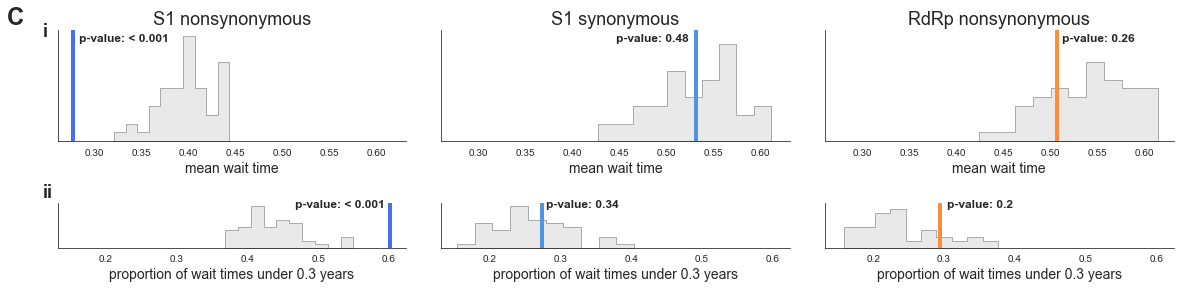

In [34]:
plot_wait_time_stats(['wait_time_stats/wait_time_stats_50_internal.json'], filename = 'plots/fig2c_20210515.png')

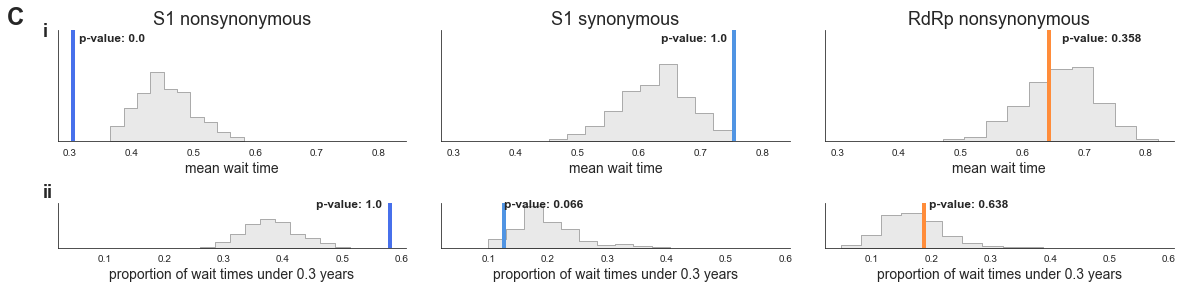

In [400]:
plot_wait_time_stats(['wait_time_stats/wait_time_stats_10its.json', 'wait_time_stats/wait_time_stats_40its.json', 
                      'wait_time_stats/wait_time_stats_50its.json', 'wait_time_stats/wait_time_stats_50more.json', 
                      'wait_time_stats/wait_time_stats_100its.json', 'wait_time_stats/wait_time_stats_250its.json'])

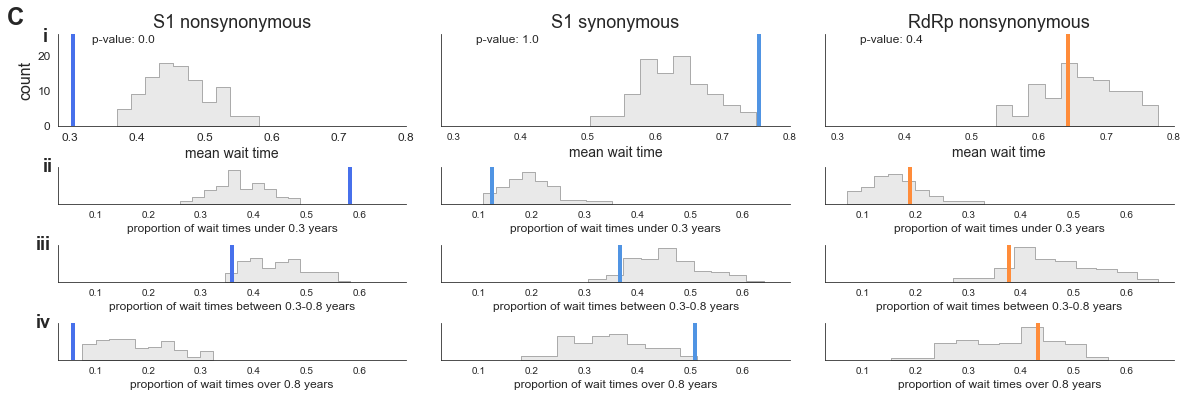

In [280]:
plot_wait_time_stats_old(['wait_time_stats/wait_time_stats_10its.json', 'wait_time_stats/wait_time_stats_40its.json', 
                      'wait_time_stats/wait_time_stats_50its.json'], filename = 'plots/fig2c_20210519_new.png')

In [25]:
def s1_wait_times(nonsyn_syn):
    # to deal with branches with multiple mutations, say that each mutation happens at a randomly chosen time 
    # between the node and previous node


    root_date = tree.root.node_attrs['num_date']['value']

    # keep track of parts of paths that have already been considered
    paths_segments_already_used_s1 = []

    # keep track of nodes (with multiple S1 mutations) where the wait times 
    # of 0 (between those mutations) have already been counted
    wait_times_already_counted_at_node = []

    # store all wait times between observed mutations
    all_wait_times_s1 = []



    for node in tree.find_clades(terminal=False):
        
        if len(node.get_terminals()) >=3:


            node_path = get_parent(tree, node)

            # find the branch length (in decimal years) between node and previous node
            path_dates = [n.node_attrs['num_date']['value'] for n in node_path]

            if len(path_dates) > 0:
                path_dates_with_root = [root_date] + path_dates
                branch_lengths = [j-i for i, j in zip(path_dates_with_root[:-1], path_dates_with_root[1:])]

            if nonsyn_syn == 'nonsyn':
                s1_muts_on_path = [n.s1_nonsyn_at_node for n in node_path]
            if nonsyn_syn == 'syn':
                s1_muts_on_path = [n.s1_syn_at_node for n in node_path]
            # indicies of branches that have S1 mutations
            s1_mut_indicies = [i for i, num_s1 in enumerate(s1_muts_on_path) if num_s1!=0]

            # count wait time from root until first mutation(s)
            if len(s1_mut_indicies) == 1:
                A_name = node_path[s1_mut_indicies[0]].name
                root_name = node_path[0].name

                if [root_name, A_name] not in paths_segments_already_used_s1:
                    num_muts_A = s1_muts_on_path[s1_mut_indicies[0]]

                    # pick date for branch A randomly between inferred node date and previous node 
                    # because mutation happened somewhere in this time window, not necessarily right at the node
                    node_date_A = node_path[s1_mut_indicies[0]].node_attrs['num_date']['value']

                    # if there are multiple mutations at this branch, assign each of them a different random date
                    dates_A = []
                    for mut in range(num_muts_A):
                        date_A = random.uniform(node_date_A - branch_lengths[s1_mut_indicies[0]], node_date_A)
                        dates_A.append(date_A)

                    dates_A = sorted(dates_A)

                    # prepend the root date
                    dates_A = [root_date] + dates_A

                    # find wait times between this branch and the root and between mutations on this branch
                    wait_times = [j-i for i, j in zip(dates_A[:-1], dates_A[1:])]
                    all_wait_times_s1+=wait_times

                    paths_segments_already_used_s1.append([root_name, A_name])
                    wait_times_already_counted_at_node.append(A_name)



            # if more than 1 mutation is on this path, calculate wait time between mutations
            if len(s1_mut_indicies) > 1:

                for x in range(len(s1_mut_indicies) -1):

                    A_name = node_path[s1_mut_indicies[x]].name
                    B_name = node_path[s1_mut_indicies[x+1]].name

                    # only count wait times if this path segment hasn't already been counted
                    if [A_name, B_name] not in paths_segments_already_used_s1:

                        num_muts_A = s1_muts_on_path[s1_mut_indicies[x]]
                        num_muts_B = s1_muts_on_path[s1_mut_indicies[x+1]]

                        # pick dates for branches A and B randomly between inferred node date and previous node 
                        # because mutation happened somewhere in this time window, not necessarily right at the node


                        # if there are multiple mutations on these branch, assign each of them a different random date
                        node_date_A = node_path[s1_mut_indicies[x]].node_attrs['num_date']['value']
                        dates_A = []
                        for mut in range(num_muts_A):
                            date_A = random.uniform(node_date_A - branch_lengths[s1_mut_indicies[x]], node_date_A)
                            dates_A.append(date_A)

                        dates_A = sorted(dates_A)


                        node_date_B = node_path[s1_mut_indicies[x+1]].node_attrs['num_date']['value']
                        dates_B = []
                        for mut in range(num_muts_B):
                            date_B = random.uniform(node_date_B - branch_lengths[s1_mut_indicies[x+1]], node_date_B)
                            dates_B.append(date_B)

                        dates_B = sorted(dates_B)


                        # find wait times between mutations on one branch
                        # only if this node hasn't already been counted
                        if A_name not in wait_times_already_counted_at_node:
                            wait_times_on_A = [j-i for i, j in zip(dates_A[:-1], dates_A[1:])]
                            all_wait_times_s1+=wait_times_on_A
                            wait_times_already_counted_at_node.append(A_name)

                        if B_name not in wait_times_already_counted_at_node:
                            wait_times_on_B = [j-i for i, j in zip(dates_B[:-1], dates_B[1:])]
                            all_wait_times_s1+=wait_times_on_B
                            wait_times_already_counted_at_node.append(B_name)

                        # and between latest mutation on branch A and earliest on branch B 
                        wait_time_between = dates_B[0] - dates_A[-1]
                        all_wait_times_s1.append(wait_time_between)



                        # add this pair of branches to the list of path segments that have already been counted
                        paths_segments_already_used_s1.append([A_name, B_name])



    return all_wait_times_s1


In [24]:
def rdrp_wait_times():
    root_date = tree.root.node_attrs['num_date']['value']

    # keep track of parts of paths that have already been considered
    paths_segments_already_used_rdrp = []

    # keep track of nodes (with multiple S1 mutations) where the wait times 
    # of 0 (between those mutations) have already been counted
    wait_times_already_counted_at_node_rdrp = []

    # store all wait times between observed mutations
    all_wait_times_rdrp = []


    for node in tree.find_clades(terminal=False):

        if len(node.get_terminals()) >=3:

            node_path = get_parent(tree, node)

            # find the branch length (in decimal years) between node and previous node
            path_dates = [n.node_attrs['num_date']['value'] for n in node_path]

            if len(path_dates) > 0:
                path_dates_with_root = [root_date] + path_dates
                branch_lengths = [j-i for i, j in zip(path_dates_with_root[:-1], path_dates_with_root[1:])]


            rdrp_muts_on_path = [n.rdrp_nonsyn_at_node for n in node_path]

            rdrp_mut_indicies = [i for i, num_rdrp in enumerate(rdrp_muts_on_path) if num_rdrp!=0]

            # count wait time from root until first mutation(s)
            if len(rdrp_mut_indicies) == 1:
                A_name = node_path[rdrp_mut_indicies[0]].name
                root_name = node_path[0].name

                if [root_name, A_name] not in paths_segments_already_used_rdrp:
                    num_muts_A = rdrp_muts_on_path[rdrp_mut_indicies[0]]

                    # pick date for branch A randomly between inferred node date and previous node 
                    # because mutation happened somewhere in this time window, not necessarily right at the node                
                    node_date_A = node_path[rdrp_mut_indicies[0]].node_attrs['num_date']['value']

                    # if there are multiple mutations at this branch, assign each of them a different random date
                    dates_A = []
                    for mut in range(num_muts_A):
                        date_A = random.uniform(node_date_A - branch_lengths[rdrp_mut_indicies[0]], node_date_A)
                        dates_A.append(date_A)

                    dates_A = sorted(dates_A)

                    # prepend the root date
                    dates_A = [root_date] + dates_A

                    # find wait times between this branch and the root and between mutations on this branch
                    wait_times = [j-i for i, j in zip(dates_A[:-1], dates_A[1:])]

                    all_wait_times_rdrp+=wait_times


                    paths_segments_already_used_rdrp.append([root_name, A_name])
                    wait_times_already_counted_at_node_rdrp.append(A_name)



            # only care if more than 1 mutation is on this path (to calculate wait time between mutations)
            if len(rdrp_mut_indicies) > 1:

                for x in range(len(rdrp_mut_indicies) -1):

                    A_name = node_path[rdrp_mut_indicies[x]].name
                    B_name = node_path[rdrp_mut_indicies[x+1]].name

                    # only count wait times if this path segment hasn't already been counted
                    if [A_name, B_name] not in paths_segments_already_used_rdrp:

                        num_muts_A = rdrp_muts_on_path[rdrp_mut_indicies[x]]
                        num_muts_B = rdrp_muts_on_path[rdrp_mut_indicies[x+1]]

                        # pick dates for branches A and B randomly between inferred node date and previous node 
                        # because mutation happened somewhere in this time window, not necessarily right at the node


                        # if there are multiple mutations on these branch, assign each of them a different random date
                        node_date_A = node_path[rdrp_mut_indicies[x]].node_attrs['num_date']['value']
                        dates_A = []
                        for mut in range(num_muts_A):
                            date_A = random.uniform(node_date_A - branch_lengths[rdrp_mut_indicies[x]], node_date_A)
                            dates_A.append(date_A)

                        dates_A = sorted(dates_A)


                        node_date_B = node_path[rdrp_mut_indicies[x+1]].node_attrs['num_date']['value']
                        dates_B = []
                        for mut in range(num_muts_B):
                            date_B = random.uniform(node_date_B - branch_lengths[rdrp_mut_indicies[x+1]], node_date_B)
                            dates_B.append(date_B)

                        dates_B = sorted(dates_B)


                        # find wait times between mutations on one branch
                        # only if this node hasn't already been counted
                        if A_name not in wait_times_already_counted_at_node_rdrp:
                            wait_times_on_A = [j-i for i, j in zip(dates_A[:-1], dates_A[1:])]
                            all_wait_times_rdrp+=wait_times_on_A
                            wait_times_already_counted_at_node_rdrp.append(A_name)

                        if B_name not in wait_times_already_counted_at_node_rdrp:
                            wait_times_on_B = [j-i for i, j in zip(dates_B[:-1], dates_B[1:])]
                            all_wait_times_rdrp+=wait_times_on_B
                            wait_times_already_counted_at_node_rdrp.append(B_name)

                        # and between latest mutation on branch A and earliest on branch B 
                        wait_time_between = dates_B[0] - dates_A[-1]
                        all_wait_times_rdrp.append(wait_time_between)

                        # add this pair of branches to the list of path segments that have already been counted
                        paths_segments_already_used_rdrp.append([A_name, B_name])


    return all_wait_times_rdrp


In [26]:
def test_expectation(iterations, test_nums, filename=None):
    #Download tree json
    tree_url = 'https://nextstrain-blab.s3.amazonaws.com/ncov_adaptive-evolution.json'

    tree_json = requests.get(tree_url).json()

    #Put tree in Bio.Phylo format
    tree = json_to_tree(tree_json)
    
    dfs_to_plot = []
    for y in test_nums:
        wait_times_random = []
        for x in range(iterations):
            randomize_mutations_on_tree_multinomial(y, branch_lengths_all, branch_names_all)
            all_wait_times_random = random_wait_times()
            wait_times_random+=all_wait_times_random


        to_plot_random = pd.DataFrame(wait_times_random, columns=['wait_times'])
        to_plot_random['num_muts'] = y
        
        dfs_to_plot.append(to_plot_random)
        
    to_plot = pd.concat(dfs_to_plot, ignore_index=True)

#     fig, ax = plt.subplots(figsize=(8,4))
    plt.figure(figsize=(12, 12))

    g = sns.FacetGrid(data=to_plot, col = 'num_muts', col_wrap =3,height=2, aspect=1.5,
                      sharex=True, sharey=True)
    
    #palette=sns.dark_palette("#ABABAB", reverse=True, n_colors=9)
    
    g.map(sns.histplot, 'wait_times', 
          element = 'step', bins=20, color="#ABABAB", alpha=0.25,
          common_norm = False, stat='probability')

    g.set_axis_labels("wait time", "probability")
    g.set_titles('{col_name} mutations', fontsize=24)
    
    sns.despine(left=False, bottom=False)
    
    if filename:
        g.savefig(filename, dpi=300, bbox_inches='tight')
    
    

In [ ]:
test_expectation(10, [50, 100, 200, 300, 400,500],  filename = 'plots/fig2_supp_20210515.png')